In [1]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
from sklearn.metrics import r2_score # モデル評価用(決定係数)
from sklearn.metrics import mean_absolute_error #モデル評価用

from sklearn import linear_model#欠損値予測用の線形回帰を生成する
from sklearn import preprocessing#単一ラベルエンコーディング用
from sklearn.preprocessing import OrdinalEncoder#複数ラベルエンコーディング用

from functools import partial
from glob import glob

import numpy as np
import pandas as pd
import pandas_profiling
import collections
import math
import copy
import pymysql
import janome
import matplotlib.pyplot as plt
import japanize_matplotlib
import optuna
import ast
import seaborn as sns
sns.set()

import lightgbm as lgb
import re

import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 31) #dfの表示を30行までに変更

from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

## 必要なデータのインポート

In [2]:
# データベースへの接続とカーソルの生成
def fetch_data(sql, cols_list):
    # データベースに接続します。
    connection = pymysql.connect(
        host='datamix-school-material.csbsmnjyxb52.ap-northeast-1.rds.amazonaws.com',
        user='user1',
        passwd='user1',
        db='advance_job_board_data',
        charset='utf8')

    try:
        with connection.cursor() as cursor:
            cursor.execute(sql)
            rows = cursor.fetchall()
            # 取得した結果をリストに代入したのちPandasのDataFrameに変換します。
            new_result = [one for one in rows]
            result = pd.DataFrame(new_result)
            result.columns = cols_list

    finally:
        connection.close()

    return result

In [3]:
# 4つのDBをcompany_idでマージするSQL文をsqlに代入します。

sql = """
SELECT 
    mas_j.company_id
    , mas_j.position
    , mas_j.job_board_info
    , lang_s.language_skillset
    , fram_s.framework_skillset
    , work_c.working_conditions
FROM
    {table_pre}_master_job_board AS mas_j
    LEFT JOIN 
        {table_pre}_language_skillset AS lang_s
        ON mas_j.company_id = lang_s.company_id
    LEFT JOIN {table_pre}_framework_skillset AS fram_s
        ON mas_j.company_id = fram_s.company_id
    LEFT JOIN {table_pre}_working_conditions AS work_c
        ON mas_j.company_id = work_c.company_id
"""

In [4]:
# sql文内のtable_preにtrainを代入します。
# DBから取り出したデータ中の使用したいカラム名を配列col_namesに格納します。
train_sql = sql.format(table_pre="train")
col_names = ["company_id", "position", "job_board_info",
             "environment_skillset", "framework_skillset", "working_conditions"]

# DBから得たデータをtrain_dataに入れます。
train = fetch_data(train_sql, col_names)
train.head()

,company_id,position,job_board_info,environment_skillset,framework_skillset,working_conditions
0,Cd346dca,サーバサイドエンジニア（開発チーム リーダー候補）,"{'employee_num': 26.0, 'location': '東京都千代田区', ...",PHP/ Python3/ JavaScript,CakePHP/ jQuery,服装自由/ イヤホンOK/ ノートPC＋モニタ別途支給/ 残業３０H以内/ フリードリンク/...
1,C713a7cd,プログラマ,"{'employee_num': 17.0, 'location': '東京都立川市', '...",Java/ C/ VB/ JavaScript/ HTML+CSS,,残業３０H以内/ 日本語がネイティブレベルでなくても可
2,C1000ca5,サーバーサイドエンジニア,"{'employee_num': 76.0, 'location': '東京都目黒区', '...",Go言語/ PHP/ Ruby/ HTML5+CSS3/ HTML+CSS,CodeIgniter/ Ruby on Rails,服装自由/ イヤホンOK/ ノートPC＋モニタ別途支給/ 裁量労働/ フリードリンク/ 若手...
3,C10010c0,バックエンドエンジニア（大阪）,"{'employee_num': 53.0, 'location': '大阪府大阪市', '...",PHP/ JavaScript/ HTML5+CSS3/ HTML+CSS/ SQL,FuelPHP/ jQuery/ Vue.js,服装自由/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋モニタ別途支給/...
4,C94ef74d,CTO候補,"{'employee_num': 30.0, 'location': '東京都新宿区', '...",PHP/ Ruby/ JavaScript/ HTML5+CSS3/ SQL,CodeIgniter/ Smarty/ Ruby on Rails/ jQuery,服装自由/ イヤホンOK/ フリーソフト利用可/ ノートPC＋モニタ別途支給/ 1920x1...


In [5]:
test_sql = sql.format(table_pre="test")
col_names = ["company_id", "position", "job_board_info",
             "environment_skillset", "framework_skillset", "working_conditions"]

test = fetch_data(test_sql, col_names)
test_company_id = fetch_data(test_sql, col_names)#最後にcompany_idを抽出するときに使う

# 特徴量生成

## job_board_infoの処理

In [6]:
#########################################
# trainの処理
#########################################
salary_train=[]
employee_train=[]
location_train=[]

for i in range(len(train)):
    job_board_info = ast.literal_eval(train["job_board_info"][i])# ast.literal_eval()で文字列を辞書型に変換
    salary_train.append(job_board_info["salary_min"])
    employee_train.append(job_board_info["employee_num"])
    location_train.append(job_board_info["location"])

train["salary"]=salary_train
train["employee"]=employee_train
train["location"]=location_train

In [7]:
train.query('employee < 4000',inplace=True)

### エラー箇所の発見方法

In [8]:
for j in range(len(test)):
    try:
        job_board_info = ast.literal_eval(test["job_board_info"][j])# ast.literal_eval()で文字列を辞書型に変換
    except:
        print(j)

433
435
440


In [9]:
test.loc[[433,435,440],["job_board_info"]]

,job_board_info
433,"{'employee_num': nan, 'location': '東京都港区'}"
435,"{'employee_num': nan, 'location': '東京都港区'}"
440,"{'employee_num': nan, 'location': '東京都渋谷区'}"


In [10]:
test["job_board_info"].replace("nan",0,inplace=True)

In [11]:
test.loc[[433,435,440],["job_board_info"]]

,job_board_info
433,"{'employee_num': nan, 'location': '東京都港区'}"
435,"{'employee_num': nan, 'location': '東京都港区'}"
440,"{'employee_num': nan, 'location': '東京都渋谷区'}"


In [12]:
#########################################
# testの処理
#########################################
employee_test=[]
location_test=[]

for j in range(len(test)):
    try:
        job_board_info = ast.literal_eval(test["job_board_info"][j])# ast.literal_eval()で文字列を辞書型に変換
    except:
        job_board_info = {"employee_num":0,"location":"東京都港区"}

    employee_test.append(job_board_info["employee_num"])
    location_test.append(job_board_info["location"])

test["salary"]=np.nan
test["employee"]=employee_test
test["location"]=location_test

# なぜか文字列の置換がうまくいかなかったのでtry構文で無理矢理回避しました。あとで直します…。

In [13]:
# 合体前に目印の付与
train["train_check"]=1
test["train_check"]=0

# データの合体
df=pd.concat([train,test])

rm_cols = [] #削除予定のカテゴリ名一覧

In [14]:
print(train.shape,test.shape)
df.head()

(1195, 10) (516, 10)


,company_id,position,job_board_info,environment_skillset,framework_skillset,working_conditions,salary,employee,location,train_check
0,Cd346dca,サーバサイドエンジニア（開発チーム リーダー候補）,"{'employee_num': 26.0, 'location': '東京都千代田区', ...",PHP/ Python3/ JavaScript,CakePHP/ jQuery,服装自由/ イヤホンOK/ ノートPC＋モニタ別途支給/ 残業３０H以内/ フリードリンク/...,510.0,26.0,東京都千代田区,1
1,C713a7cd,プログラマ,"{'employee_num': 17.0, 'location': '東京都立川市', '...",Java/ C/ VB/ JavaScript/ HTML+CSS,,残業３０H以内/ 日本語がネイティブレベルでなくても可,300.0,17.0,東京都立川市,1
2,C1000ca5,サーバーサイドエンジニア,"{'employee_num': 76.0, 'location': '東京都目黒区', '...",Go言語/ PHP/ Ruby/ HTML5+CSS3/ HTML+CSS,CodeIgniter/ Ruby on Rails,服装自由/ イヤホンOK/ ノートPC＋モニタ別途支給/ 裁量労働/ フリードリンク/ 若手...,400.0,76.0,東京都目黒区,1
3,C10010c0,バックエンドエンジニア（大阪）,"{'employee_num': 53.0, 'location': '大阪府大阪市', '...",PHP/ JavaScript/ HTML5+CSS3/ HTML+CSS/ SQL,FuelPHP/ jQuery/ Vue.js,服装自由/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋モニタ別途支給/...,350.0,53.0,大阪府大阪市,1
4,C94ef74d,CTO候補,"{'employee_num': 30.0, 'location': '東京都新宿区', '...",PHP/ Ruby/ JavaScript/ HTML5+CSS3/ SQL,CodeIgniter/ Smarty/ Ruby on Rails/ jQuery,服装自由/ イヤホンOK/ フリーソフト利用可/ ノートPC＋モニタ別途支給/ 1920x1...,600.0,30.0,東京都新宿区,1


# EDA(特徴量生成前)

In [15]:
df.describe()

,salary,employee,train_check
count,1195.000000,1711.000000,1711.000000
mean,417.781590,133.691409,0.698422
std,89.964557,334.299511,0.459077
min,220.000000,0.000000,0.000000
25%,360.000000,20.000000,0.000000
50%,400.000000,42.000000,1.000000
75%,450.000000,100.000000,1.000000
max,800.000000,3365.000000,1.000000


# 特徴量の生成・値の補完

## framework_skillsetの処理

In [16]:
temp3 = train["framework_skillset"].unique() # ユニークな状態に整理する(計算時間が掛かるため)
temp4 = [str(ele).replace("\u3000", "/") for ele in temp3] # リスト内包表記
temp5 = "/".join(temp4) # リスト同士を/で区切った状態で1つの文字列に変換する
temp6 = pd.Series(temp5.split("/")).unique()# /を基準にリスト分割

temp7 = []

for i in temp6:
    temp7.append(i.replace(" ",""))

framework_skillset_unique = list(pd.Series(temp7).unique())

In [17]:
for j in framework_skillset_unique:
    try:
        df[j] = df["framework_skillset"].str.contains(j).astype(int)
    except:
        df[j] = 0
        
#nanでエラーが出るので無理矢理回避しています

## language_skillsetの処理

In [18]:
temp3 = train["environment_skillset"].unique() # ユニークな状態に整理する(計算時間が掛かるため)
temp4 = [str(ele).replace("\u3000", "/") for ele in temp3] # リスト内包表記
temp5 = "/".join(temp4) # リスト同士を/で区切った状態で1つの文字列に変換する
temp6 = pd.Series(temp5.split("/")).unique()# /を基準にリスト分割

temp7 = []

for i in temp6:
    temp7.append(i.replace(" ",""))

language_skillset_unique = list(pd.Series(temp7).unique())

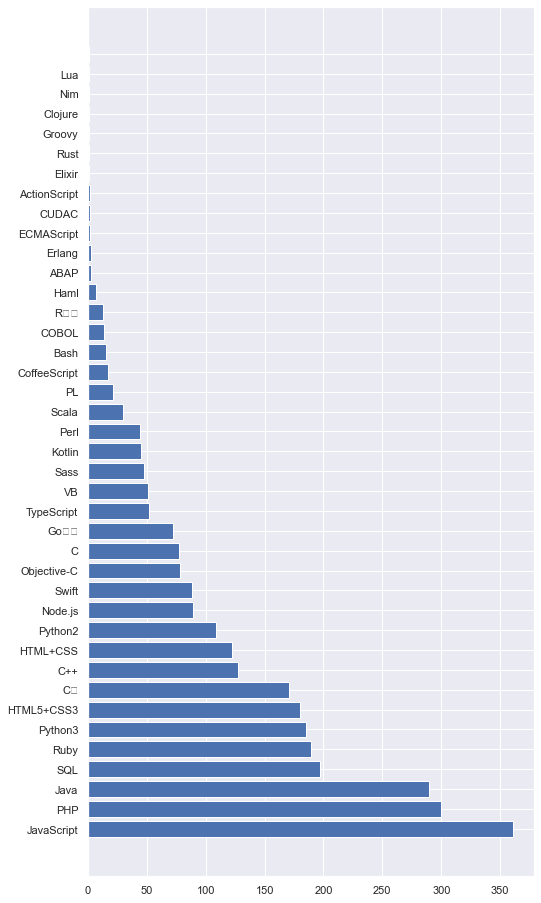

['CoffeeScript',
 'Bash',
 'COBOL',
 'R言語',
 'Haml',
 'ABAP',
 'Erlang',
 'ECMAScript',
 'CUDAC',
 'ActionScript',
 'Elixir',
 'Rust',
 'Groovy',
 'Clojure',
 'Nim',
 'Lua',
 '']

In [19]:
# 言語別の出現回数のカウント
language_counts = pd.Series(temp5.replace(" ","").split("/")).value_counts()
language_counts_df = pd.DataFrame(language_counts).reset_index().rename(columns={"index":"langage",0:"value_counts"})

# 言語別件数の可視化
fig, ax = plt.subplots(figsize=(8.0, 16.0))
labels = language_counts_df["langage"]
plt.barh(range(len(language_counts_df)),language_counts_df["value_counts"])
plt.yticks(range(len(language_counts_df)), labels)
plt.show()

# 結果を元に方向性の決定：20未満の言語はないほうが綺麗に分割できるのでは。最後に削除処理を入れる

# 20未満の言語のみ抽出・リスト化
Del_LanguageList = list(language_counts_df[language_counts_df["value_counts"]<20]["langage"])
Del_LanguageList

In [20]:
# one-hot-encoding状態
for j in language_skillset_unique:
    try:
        df[j] = df["environment_skillset"].str.contains(j).astype(int)
    except:
        df[j] = 0

## 特徴量：num_of_languageの作成

In [21]:
temp8 = []

for k in range(len(df)):
    try:
        temp8.append(str(df["environment_skillset"].iloc[k,["environment_skillset"]]).count("/")+1)
    except:
        temp8.append(0)

df["num_of_language"] = temp8

In [22]:
df.head()

,company_id,position,job_board_info,environment_skillset,framework_skillset,working_conditions,salary,employee,location,train_check,...,Groovy,Haml,Lua,COBOL,ABAP,ECMAScript,Nim,Erlang,ActionScript,num_of_language
0,Cd346dca,サーバサイドエンジニア（開発チーム リーダー候補）,"{'employee_num': 26.0, 'location': '東京都千代田区', ...",PHP/ Python3/ JavaScript,CakePHP/ jQuery,服装自由/ イヤホンOK/ ノートPC＋モニタ別途支給/ 残業３０H以内/ フリードリンク/...,510.0,26.0,東京都千代田区,1,...,0,0,0,0,0,0,0,0,0,0
1,C713a7cd,プログラマ,"{'employee_num': 17.0, 'location': '東京都立川市', '...",Java/ C/ VB/ JavaScript/ HTML+CSS,,残業３０H以内/ 日本語がネイティブレベルでなくても可,300.0,17.0,東京都立川市,1,...,0,0,0,0,0,0,0,0,0,0
2,C1000ca5,サーバーサイドエンジニア,"{'employee_num': 76.0, 'location': '東京都目黒区', '...",Go言語/ PHP/ Ruby/ HTML5+CSS3/ HTML+CSS,CodeIgniter/ Ruby on Rails,服装自由/ イヤホンOK/ ノートPC＋モニタ別途支給/ 裁量労働/ フリードリンク/ 若手...,400.0,76.0,東京都目黒区,1,...,0,0,0,0,0,0,0,0,0,0
3,C10010c0,バックエンドエンジニア（大阪）,"{'employee_num': 53.0, 'location': '大阪府大阪市', '...",PHP/ JavaScript/ HTML5+CSS3/ HTML+CSS/ SQL,FuelPHP/ jQuery/ Vue.js,服装自由/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋モニタ別途支給/...,350.0,53.0,大阪府大阪市,1,...,0,0,0,0,0,0,0,0,0,0
4,C94ef74d,CTO候補,"{'employee_num': 30.0, 'location': '東京都新宿区', '...",PHP/ Ruby/ JavaScript/ HTML5+CSS3/ SQL,CodeIgniter/ Smarty/ Ruby on Rails/ jQuery,服装自由/ イヤホンOK/ フリーソフト利用可/ ノートPC＋モニタ別途支給/ 1920x1...,600.0,30.0,東京都新宿区,1,...,0,0,0,0,0,0,0,0,0,0


## working_conditionsの処理 ⇒ 説明力が低いので個人的に削除

In [23]:
# temp3 = train["working_conditions"].unique() # ユニークな状態に整理する(計算時間が掛かるため)
# temp4 = [str(ele).replace("\u3000", "/") for ele in temp3] # リスト内包表記
# temp5 = "/".join(temp4) # リスト同士を/で区切った状態で1つの文字列に変換する
# temp6 = pd.Series(temp5.split("/")).unique()# /を基準にリスト分割

# temp7 = []

# for i in temp6:
#     temp7.append(i.replace(" ",""))

# working_conditions_unique = list(pd.Series(temp7).unique())

In [24]:
# for j in working_conditions_unique:
#     try:
#         df[j] = df["working_conditions"].str.contains(j).astype(int)
#     except:
#         df[j] = 0
        
###################################################
# 福利厚生が直接的に給料に起因することは考えにくいのでは
# 例.「服装自由」(だから)給料が高い …?　これは因果がおかしい
# 恐らく別の因子「成果主義」だから「服装自由」だし「給料が高い」というロジック
###################################################

## 特徴量：area_name(都道府県)の作成

In [25]:
df["area_name"] = df["location"].apply(lambda x:str(x)[:2])
df["area_name"].unique()

array(['東京', '大阪', '愛知', '北海', '岡山', '沖縄', '兵庫', '福岡', '滋賀', '京都', '神奈',
       '静岡', '香川', '奈良', '福井', '大分', '広島', '佐賀', '埼玉', '茨城', '千葉', '宮城',
       '長野', '宮崎', '和歌', '山梨', '熊本', '新潟', '富山', '岐阜', '海外', '長崎', '石川',
       '岩手', '群馬', '三重', '島根'], dtype=object)

## positionの処理

In [26]:
df["position"].unique()

array(['サーバサイドエンジニア（開発チーム\u3000リーダー候補）', 'プログラマ', 'サーバーサイドエンジニア',
       'バックエンドエンジニア（大阪）', 'CTO候補', 'Web開発エンジニア',
       'AI・データサイエンス・データエンジニア\u3000職', 'AIエンジニア', 'AIエンジニア（北海道）',
       'ヘルスケアIoT◎マネージャー候補', 'RPAエンジニア', '新規事業開発エンジニア', '開発・運用エンジニア',
       'Railsエンジニア（大阪）', 'フロントエンドエンジニア（大阪）', '開発エンジニア（リーダークラス）',
       '技師、主幹技師', 'webエンジニア', 'サーバーサイドエンジニア（大阪）', 'システムエンジニア',
       'バックエンドエンジニア', 'SRE（Site Reliability Engineering）', 'フロントエンドエンジニア',
       'サーバサイドエンジニア', 'クラウドサービス開発エンジニア', 'データベースエンジニア（大阪）', 'シニアエンジニア',
       'クライアントアプリ開発エンジニア', 'メールフィルタリングソフトの開発エンジニア ', 'アプリ開発エンジニア',
       'Webエンジニア（名古屋）', 'システムエンジニア（沖縄）', 'iOSアプリエンジニア', 'ロボットクリエイターリーダー',
       'Androidアプリエンジニア', 'ソフトウェアエンジニア', 'サーバサイドエンジニア（リードクラス）',
       'Webエンジニア', '自社サービスWEBエンジニア', 'プロダクトオーナー', 'Web開発エンジニア（リーダー候補）',
       'アプリ開発エンジニア(iOS)', '社内SE', 'iOS開発エンジニア', 'バックエンドのリードエンジニア',
       'スクラムマスター', 'Webエンジニア／フロントエンド（名古屋）', 'Railsエンジニア',
       'サーバサイドエンジニア（Railsエンジニア）', 'インフラエンジニア（名古屋）', 'SREエンジニア',
       'シス

In [27]:
df["position"].replace(r"\（.+\）","",inplace=True, regex=True)
df["position"].replace(r"\(.+\)","",inplace=True, regex=True)
df["position"].replace(r"\(.+\）","",inplace=True, regex=True)
df["position"].replace(r"\【.+\】","",inplace=True, regex=True)
df["position"].replace(r"\＜.+\＞","",inplace=True, regex=True)
df["position"].replace("\u3000","",inplace=True, regex=True)
df["position"].replace(" ","",inplace=True, regex=True)

In [28]:
df["position"].unique()

array(['サーバサイドエンジニア', 'プログラマ', 'サーバーサイドエンジニア', 'バックエンドエンジニア', 'CTO候補',
       'Web開発エンジニア', 'AI・データサイエンス・データエンジニア職', 'AIエンジニア',
       'ヘルスケアIoT◎マネージャー候補', 'RPAエンジニア', '新規事業開発エンジニア', '開発・運用エンジニア',
       'Railsエンジニア', 'フロントエンドエンジニア', '開発エンジニア', '技師、主幹技師', 'webエンジニア',
       'システムエンジニア', 'SRE', 'クラウドサービス開発エンジニア', 'データベースエンジニア', 'シニアエンジニア',
       'クライアントアプリ開発エンジニア', 'メールフィルタリングソフトの開発エンジニア', 'アプリ開発エンジニア',
       'Webエンジニア', 'iOSアプリエンジニア', 'ロボットクリエイターリーダー', 'Androidアプリエンジニア',
       'ソフトウェアエンジニア', '自社サービスWEBエンジニア', 'プロダクトオーナー', '社内SE', 'iOS開発エンジニア',
       'バックエンドのリードエンジニア', 'スクラムマスター', 'Webエンジニア／フロントエンド', 'インフラエンジニア',
       'SREエンジニア', 'i-FILTER開発エンジニア', 'マーケティング情報解析システム開発エンジニア',
       'システム開発エンジニア', 'Unityエンジニア', 'WEBシステム開発エンジニア、PM候補', 'プロジェクトマネージャー',
       'エンジニア', 'RubyonRailsエンジニア', 'フルスタックエンジニア', 'クラウド開発エンジニア',
       'プロダクトマネージャー', 'Webアプリケーションエンジニア', 'SET', 'スマートフォンアプリエンジニア',
       'WEBエンジニア', 'iOS/Android開発エンジニア', 'iOSエンジニア', 'PHPエンジニア',
       'シニアWebソリューションエンジニア', 'Androidエ

# EDA(特徴量生成後)

### htmlレポートメモ
- company_id 重複なし
- framework_skillset distinct50% 細かく分類しないで良いのでは。n数が一定値以上の変数のみにする
- language_skillset 重複は少なめ20が最大、これは分類しないと判断できない
- salary 400万円が突出している。正規分布のような見た目をしている
- employee ほとんどが200前後、9474が1件あるけど異常値だと思う。

In [29]:
# htmlで出力
# report = train.profile_report()
# report.to_file("train_report.html")

In [30]:
# 欠損値・データ型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1711 entries, 0 to 515
Columns: 101 entries, company_id to area_name
dtypes: float64(2), int32(88), int64(3), object(8)
memory usage: 775.3+ KB


In [31]:
df.describe()

,salary,employee,train_check,CakePHP,jQuery,,CodeIgniter,RubyonRails,FuelPHP,Vue.js,...,Groovy,Haml,Lua,COBOL,ABAP,ECMAScript,Nim,Erlang,ActionScript,num_of_language
count,1195.000000,1711.000000,1711.000000,1711.000000,1711.000000,1711.0,1711.000000,1711.0,1711.000000,1711.000000,...,1711.000000,1711.000000,1711.000000,1711.000000,1711.000000,1711.000000,1711.000000,1711.000000,1711.000000,1711.0
mean,417.781590,133.691409,0.698422,0.113968,0.239626,1.0,0.021040,0.0,0.052016,0.080655,...,0.001169,0.005845,0.001169,0.030392,0.004676,0.001169,0.000584,0.002338,0.005260,0.0
std,89.964557,334.299511,0.459077,0.317866,0.426980,0.0,0.143561,0.0,0.222125,0.272384,...,0.034179,0.076248,0.034179,0.171712,0.068238,0.034179,0.024175,0.048309,0.072357,0.0
min,220.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,360.000000,20.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,400.000000,42.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,450.000000,100.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,800.000000,3365.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


## 外れ値の処理

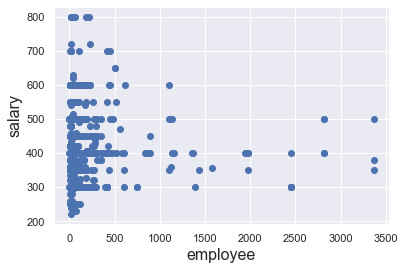

In [32]:
plt.scatter(train["employee"],train["salary"])
plt.xlabel("employee", fontsize=16) #x軸ラベル
plt.ylabel("salary", fontsize=16) #y軸ラベル
plt.show()

In [33]:
# train.query('employee < 4000',inplace=True)
# 本当はここにいれたいが処理の都合上、インポート直後に移動しておく

## 不要カラムの削除

In [34]:
rm_cols +=[
    "company_id",
    "framework_skillset",
    "environment_skillset",
    "job_board_info",
    "working_conditions"
]

df.drop(rm_cols,axis=1,inplace=True)

In [35]:
# 作り過ぎた言語列の削除

for del_language in Del_LanguageList:
    df.drop([del_language],axis=1,inplace=True)

In [36]:
df.columns

Index(['position', 'salary', 'employee', 'location', 'train_check', 'CakePHP',
       'jQuery', 'CodeIgniter', 'RubyonRails', 'FuelPHP', 'Vue.js', 'Smarty',
       'Symfony', '.NETFramework', 'AndroidSDK', 'AngularJS', 'PlayFramework',
       '自社フレームワーク', 'TensorFlow', 'Laravel', 'Spring', 'Django', 'Seasar2',
       'React', 'Struts', 'Node.js', 'Bootstrap', 'JavaEE', 'ZendFramework',
       'iOSSDK', 'Backbone.js', 'Gin', 'iBATIS', 'JSF', 'Unity', 'MyBatis',
       'Flask', 'Tornado', 'cocos2d-x', 'cocos2d', 'OpenGL', 'Hibernate',
       'Phalcon', 'Catalyst', 'Ethna', 'Chainer', 'Caffe', 'Sinatra', 'Echo',
       'Slim', 'UnrealEngine', 'DirectX', 'Pyramid', 'prototype.js',
       'DojoToolkit', 'PHP', 'Python3', 'JavaScript', 'Java', 'C', 'VB',
       'HTML+CSS', 'Go言語', 'Ruby', 'HTML5+CSS3', 'SQL', 'C++', 'C＃', 'Scala',
       'Swift', 'Kotlin', 'Python2', 'TypeScript', 'Objective-C', 'Perl',
       'Sass', 'PL', 'num_of_language', 'area_name'],
      dtype='object')

## エンコーディング

In [37]:
# one-hotエンコーディング(カテゴリを0.1に変換する)
df = pd.get_dummies(df,columns=["position"])

In [38]:
# ラベルエンコーディング(カテゴリを1.2.3.…と連番に変換する)
oe = preprocessing.OrdinalEncoder()
encoded = oe.fit_transform(df[["location","area_name"]].values)#数値に変換したリスト
decoded = oe.inverse_transform(encoded)#元の文字列に戻したリスト

df[["location","area_name"]]=encoded#代入
df.head()

,salary,employee,location,train_check,CakePHP,jQuery,CodeIgniter,RubyonRails,FuelPHP,Vue.js,...,position_開発マネージャ候補,position_開発メンバー,position_開発リーダー,position_開発リードエンジニア,position_開発・運用エンジニア,position_開発事業部リーダー,position_開発事業部事業部長,position_ＡＩエンジニア,position_ＩＴエンジニア,position_ＳＥ／リーダー候補
0,510.0,26.0,52.0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,300.0,17.0,69.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,400.0,76.0,67.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,350.0,53.0,21.0,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,600.0,30.0,59.0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# dfの整理

In [39]:
train_df = df[df["train_check"]==1].drop(["train_check"],axis=1) 
test_df = df[df["train_check"]==0] .drop(["train_check"],axis=1)

print(train_df.shape,test_df.shape)

(1195, 570) (516, 570)


In [40]:
train_y=train_df["salary"]
train_X=train_df.drop(["salary"],axis=1)
test_y=test_df["salary"]
test_X=test_df.drop(["salary"],axis=1)

In [41]:
train_X, val_X, train_y, val_y = train_test_split(train_X,train_y,test_size=0.3,random_state=0)

print(train_X.shape, val_X.shape, train_y.shape, val_y.shape)

(836, 569) (359, 569) (836,) (359,)


# ランダムフォレストの実装

In [42]:
# ランダムフォレストの実装
from sklearn.ensemble import RandomForestRegressor

# 学習
forest = RandomForestRegressor(
    criterion="mse",
    max_depth=60,
    random_state=42,
    n_estimators=300,#決定木の数。デフォルトは10だが少なすぎ。
    max_features=300
)

forest.fit(train_X,train_y)

# 予測値算出
test_pred = forest.predict(test_X)

1   salary   0.0815515573237044
2   employee   0.06595149451456628
3   position_リードWebエンジニア   0.02692977342443852
4   RubyonRails   0.02304343292641342
5   JavaScript   0.021516245188210836
6   Python3   0.019137565504234903
7   PL   0.018677618378060905
8   position_SE・PG／組込系ソフトウェア開発エンジニア   0.01753799040500365
9   VB   0.016698150965387473
10   position_BrSE/PL/PM   0.016567889087811663
11   Swift   0.015822984407021363
12   HTML+CSS   0.015325277675720278
13   position_CTO   0.014849517603004875
14   position_テストエンジニア   0.014537299137750183
15   prototype.js   0.01419435582568597
16   train_check   0.013159704314127128
17   DojoToolkit   0.012852631637672871
18   React   0.012196101999389647
19   position_新規事業開発エンジニア   0.011936007910050667
20   position_Androidエンジニア   0.011464504712125238


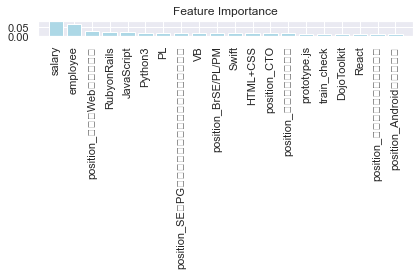

In [43]:
#特徴量の重要度
feature = forest.feature_importances_

f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)

#特徴量の名前
label = df.columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

# for i in range(len(feature)):#全て表示したいとき
for i in range(20):#20位まで表示したいとき
    print(str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.title('Feature Importance')
plt.bar(range(20),feature[indices][0:20], color='lightblue', align='center')
plt.xticks(range(20), label[indices][0:20], rotation=90)
plt.xlim([-1, 20])
plt.tight_layout()
plt.show()

In [44]:
# SHAPを使って特徴量の貢献度を把握する⇒処理重いので注意

# !pip install shap
# !pip install -U tqdm
import shap
 
shap.initjs()
 
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(train_X) # X_trainは訓練データのpandas.DataFrame
 
shap.force_plot(explainer.expected_value, shap_values[0,:], train_X.iloc[0,:])

In [45]:
output = pd.DataFrame(columns=['company_id', 'salary_min']) #カラム名のみ入った空のdfを生成する
output["company_id"] = test_company_id["company_id"]
output["salary_min"] = test_pred

output.to_csv('data/test_submission.csv', header=True,index=False)

# 結論

## FeatureImportanseのTop20を見ると、従業員数,position,使用言語の影響が大きい
- positionは具体的には「PL」「position_リードWebエンジニア」だと影響が大きい
- 使用言語としては「Ruby on Rails」「Java Script」「Python3」の影響が大きい